<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/2_Seal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net seal detection

In [1]:
#Connect to the google drive if you use Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
!pip install torch torchvision segmentation-models-pytorch tifffile tabulate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.7 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torchvision
from PIL import Image
import torch.nn.functional as F
import zipfile
import time
from tabulate import tabulate
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import random
import torchvision.transforms.functional as TF

### Define path to tensor files and load train and test data


In [4]:
zip_path = "/content/drive/MyDrive/SealNN/data.zip"
data_path = "/content/drive/MyDrive/SealNN/"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [29]:
# Choose RGB or BW
col = "panchromatic" # BW
# col = "pansharpened" # RGB

train_data_path = "/content/drive/MyDrive/SealNN/data/"+ col + "/train" #TODO: change to relative file path
val_data_path = "/content/drive/MyDrive/SealNN/data/"+ col + "/val"
test_data_path = "/content/drive/MyDrive/SealNN/data/"+ col + "/test"


In [30]:
def trans(image, mask):
    # Convert to tensor
    image = TF.to_tensor(image).float() / 255.0 # get pixel values between 0 and 1 for uint8
    mask = TF.to_tensor(mask).float() # Ensure mask is also in float32

    # Set a random seed
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)

    # Apply horizontal flip with 50% probability
    if random.random() < 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if image.shape[0] != 1:
        image = image[:3, :, :]  # Assumes that first three channels are RGB
        mask = mask.repeat(3, 1, 1)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        image = TF.normalize(image, mean=0.445, std=0.269)

    return image, mask


def denormalize(image_tensor): #This is for denormalization for visualisation purposes
    if image_tensor.shape[0] != 1:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image_tensor.device)
    else:
        mean = torch.tensor([0.5]).view(1, 1, 1).to(image_tensor.device)
        std = torch.tensor([0.5]).view(1, 1, 1).to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    return image_tensor

#Custom dataset to properly import for segmentation
def segmentation_dataset(data_path, transform=None):
   images_path = os.path.join(data_path, "images")
   masks_path = os.path.join(data_path, "masks")
   image_files = os.listdir(images_path)

   dataset = []
   for img_name in image_files:
         image = tifffile.imread(os.path.join(images_path, img_name)) #read .tif file
         mask = tifffile.imread(os.path.join(masks_path, img_name[:-4] + '.tif')) #read corresponding mask .tif file

         if transform:
           image, mask = trans(image, mask)
           #mask = transform(mask) #apply transform to both image and corresponding mask

         dataset.append((image, mask)) #append the image-mask pair in the dataset

   return dataset

# Create train and test datasets without augmentation
train_dataset = segmentation_dataset(train_data_path, transform=trans)
val_dataset = segmentation_dataset(val_data_path, transform=trans)
test_dataset = segmentation_dataset(test_data_path, transform=trans)

batch_size = 8 #Can be changed later

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
image, mask = train_dataset[130]
print(image.shape, type(image))
print(mask.shape, type(image))
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(f'STD: {torch.std(image)}, Mean: {torch.mean(image)}')

torch.Size([1, 224, 224]) <class 'torch.Tensor'>
torch.Size([1, 224, 224]) <class 'torch.Tensor'>
720 133 47
STD: 0.2877880334854126, Mean: -0.7561430931091309


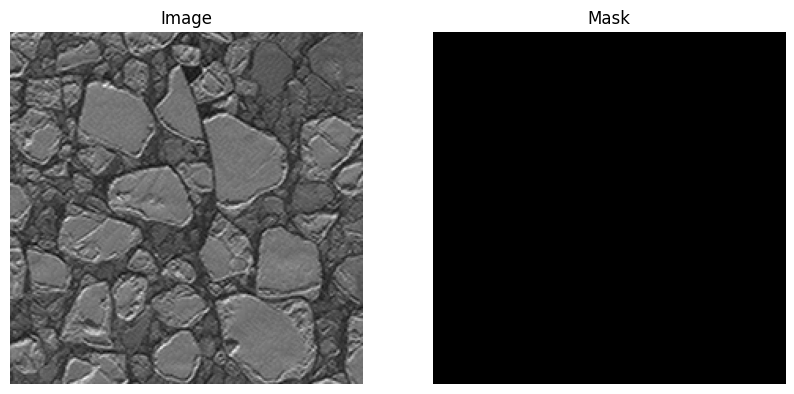

STD: 0.24308502674102783, Mean: -0.6890208125114441, Min: -1.450178623199463, Max: 0.5616300106048584
torch.Size([1, 224, 224])


In [32]:
image, mask = train_dataset[125]
channels = image.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(denormalize(image).permute(1,2,0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1,2,0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

print(f'STD: {torch.std(image)}, Mean: {torch.mean(image)}, Min: {torch.min(image)}, Max: {torch.max(image)}')
print(image.shape)

#### Check GPU

In [20]:
#check the GPU colab assigns to you
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 20 13:55:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P0              28W /  72W |   6287MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Define the model (U-Net)

In [33]:
#source:https://smp.readthedocs.io/en/latest/models.html#unet
model = smp.Unet(
    encoder_name="efficientnet-b7",         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',             # imagenet if using pretrained, None is no pretraining
    in_channels=channels,                   # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=channels                        # model output channels (number of classes in your dataset)

)

### Training and testing

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/30, Train Loss: 0.5772, Val Loss: 0.9876, Epoch time:  20.89s, LR: 0.003
Epoch 2/30, Train Loss: 0.3201, Val Loss: 0.9152, Epoch time:  21.09s, LR: 0.003
Epoch 3/30, Train Loss: 0.2788, Val Loss: 0.2549, Epoch time:  20.97s, LR: 0.003
Epoch 4/30, Train Loss: 0.2400, Val Loss: 0.3241, Epoch time:  21.03s, LR: 0.003
Epoch 5/30, Train Loss: 0.2224, Val Loss: 0.3115, Epoch time:  21.04s, LR: 0.003
Epoch 6/30, Train Loss: 0.2069, Val Loss: 0.3635, Epoch time:  21.21s, LR: 0.003
Epoch 7/30, Train Loss: 0.2155, Val Loss: 0.4130, Epoch time:  21.14s, LR: 0.003
Epoch 8/30, Train Loss: 0.1774, Val Loss: 0.5360, Epoch time:  21.13s, LR: 0.003
Epoch 9/30, Train Loss: 0.2116, Val Loss: 0.2216, Epoch time:  21.25s, LR: 0.003
Epoch 10/30, Train Loss: 0.1927, Val Loss: 0.2818, Epoch time:  21.37s, LR: 0.003
Epoch 11/30, Train Loss: 0.1883, Val Loss: 0.2825, Epoch time:  21.45s, LR: 0.003
Epoch 12/30, Train Loss: 0.1659, Val Loss: 0.3326, Epoch time:  21.18s, LR: 0.003
Epoch 13/30, Train Loss: 

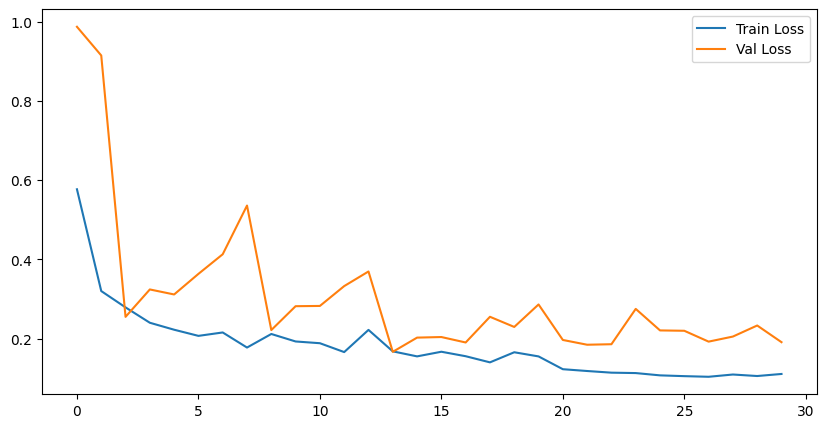

In [34]:
learning_rate = 0.003
num_epochs = 30
# Define the loss function and optimizer
# Tversky loss https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
alpha = 0.1
beta = 0.9



#https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/metric.py
def metrics(groundtruths, predictions, threshold = 0.5):
        output = torch.cat(groundtruths, dim = 0)
        target = torch.cat(predictions, dim = 0)
        #pred = (all_outputs > threshold).float()

        #output = predictions.view(-1, )
        #target = groundtruths.view(-1, ).float()

        tp = torch.sum(output * target)  # TP
        fp = torch.sum(output * (1 - target))  # FP
        fn = torch.sum((1 - output) * target)  # FN
        tn = torch.sum((1 - output) * (1 - target))  # TN

        eps = 1e-7 # Small number to avoid devision by zero

        pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
        precision = (tp + eps) / (tp + fp + eps)
        recall = (tp + eps) / (tp + fn + eps)
        specificity = (tn + eps) / (tn + fp + eps)

        table = [["Pixel Accuracy", pixel_acc],
                 ["Dice", dice],
                 ["Precision", precision],
                 ["Recall", recall],
                 ["Specificity", specificity]]

        head = ["Metric", "Value"]

        print(tabulate(table, headers=head, tablefmt="grid"))

        return pixel_acc, dice, precision, recall, specificity

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=alpha, beta=beta):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

        return 1 - Tversky



# What loss function do we want
criterion = TverskyLoss()
#criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss with logits

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training and validation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

best_loss = 10000000
best_model = 0
best_epoch = 0

for epoch in range(num_epochs):
    start_time = time.time() #start time for epoch

    model.train()
    train_loss = 0.0
    tr_all_outputs = []
    tr_all_masks = []
    for image, mask in train_loader:
        image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, mask) #mask.float() maybe?
        loss.backward()
        optimizer.step()
        outputs = torch.sigmoid(outputs)
        outputs= outputs.cpu().detach()
        tr_all_outputs.append(outputs)
        tr_all_masks.append(mask.cpu().detach())
        train_loss += loss.item()


    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_all_outputs = []
    val_all_masks = []
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
            outputs = model(image)
            loss = criterion(outputs, mask) #mask.float() maybe?
            outputs = torch.sigmoid(outputs)
            outputs= outputs.cpu().detach()
            val_all_outputs.append(outputs)
            val_all_masks.append(mask.cpu().detach())
            val_loss += loss.item()


    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model
      best_epoch = epoch+1


    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch time: {epoch_time: .2f}s, LR: {get_lr(optimizer)}')
print(f"Best epoch is {best_epoch}, with a validation loss of {best_loss}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [35]:
# Run this code if your model is good, you can save the weights to drive:
import os.path
from os import path

if path.exists("/content/drive/MyDrive/SealNN/models") == False:
  os.mkdir("/content/drive/MyDrive/SealNN/models")

model_name = "Model_33" # Make sure you change the name to the ID number we used in the excel!
model_path = "/content/drive/MyDrive/SealNN/models/"+ model_name
torch.save(best_model, model_path)

## Test accuracy and precision/recall curve

precision = how many of the ground truth instances are found?
recall = how many of the predicted instances are correct?

+----------------+----------+
| Metric         |    Value |
+================+==========+
| Pixel Accuracy | 0.999188 |
+----------------+----------+
| Dice           | 0.719788 |
+----------------+----------+
| Precision      | 0.591385 |
+----------------+----------+
| Recall         | 0.919415 |
+----------------+----------+
| Specificity    | 0.999279 |
+----------------+----------+


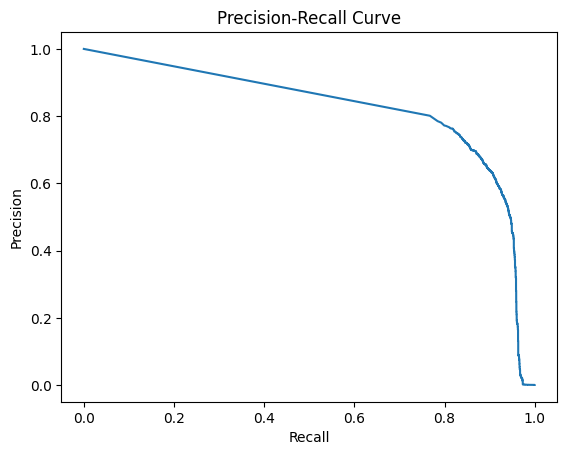

In [36]:
# Evaluate the model and collect outputs and masks
best_model.eval()

te_all_outputs = []
te_all_masks = []

for image, mask in test_loader:
    image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
    outputs = best_model(image)

    outputs = torch.sigmoid(outputs)  # Assuming the output is a logit
    outputs = outputs.cpu().detach()

    te_all_outputs.append(outputs)
    te_all_masks.append(mask.cpu().detach())


metrics(te_all_outputs, te_all_masks)

te_all_outputs = torch.cat(te_all_outputs).view(-1)
te_all_masks = torch.cat(te_all_masks).view(-1)


te_all_outputs_np = te_all_outputs.numpy()
te_all_masks_np = te_all_masks.numpy()

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(te_all_masks_np, te_all_outputs_np)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, marker=' ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


# Prediction visualisation


<ipython-input-37-f5495005c194>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(6, 2))


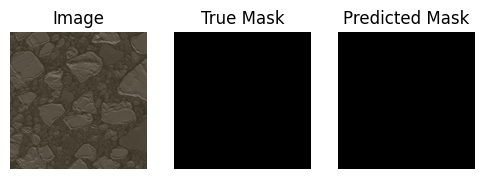

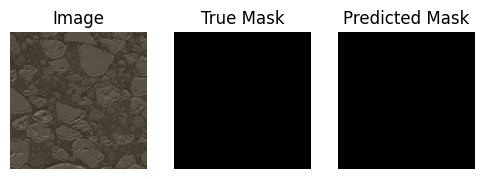

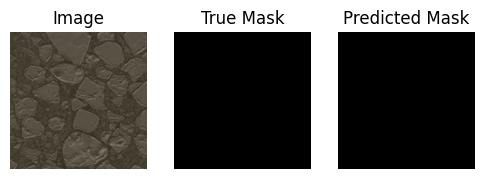

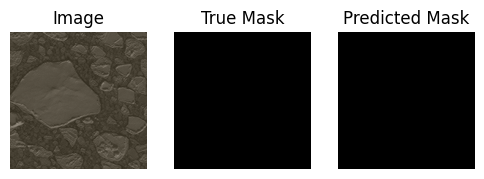

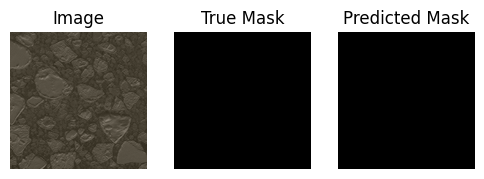

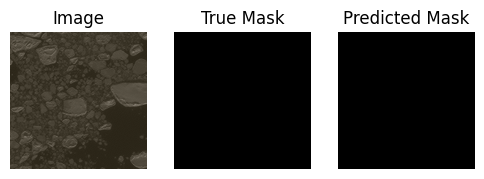

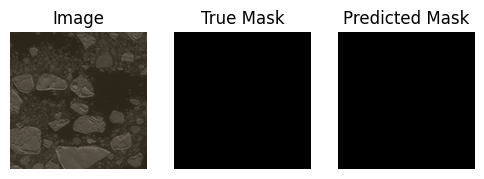

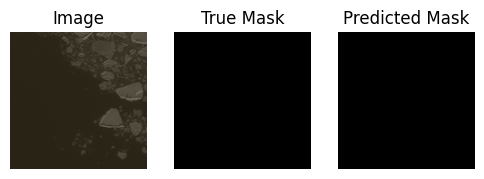

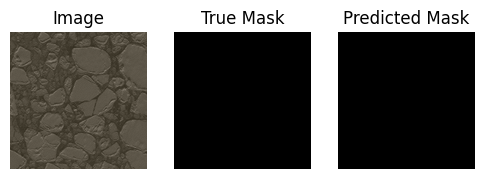

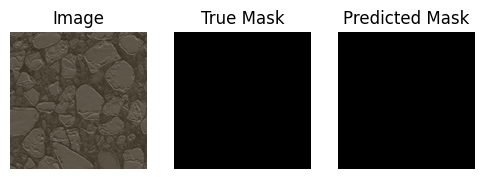

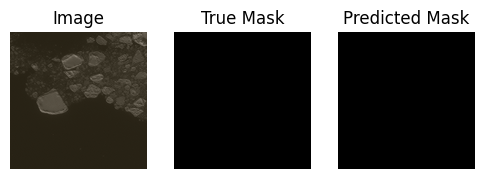

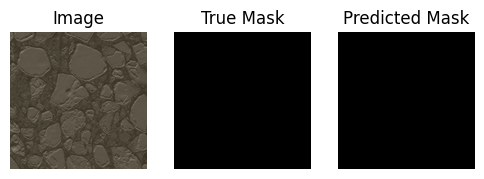

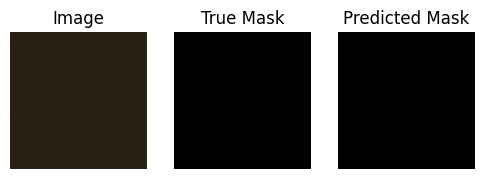

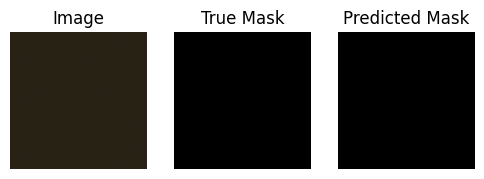

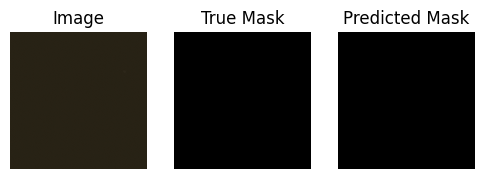

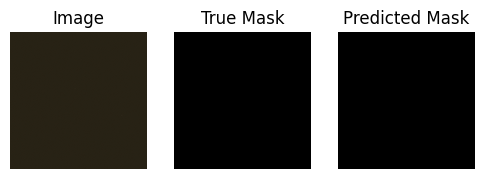

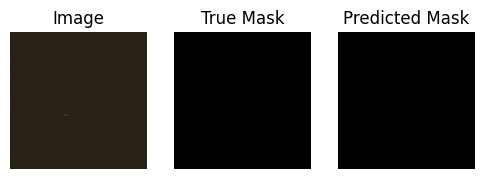

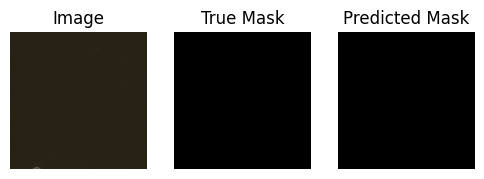

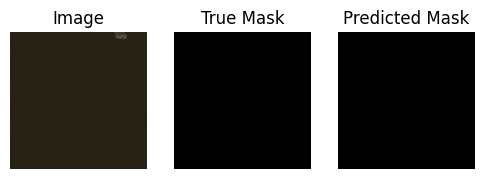

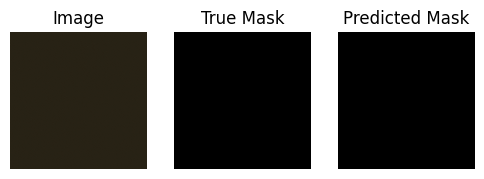

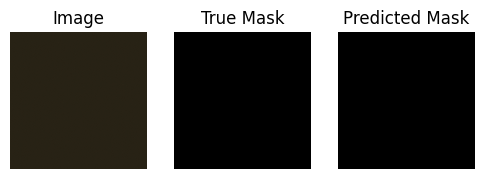

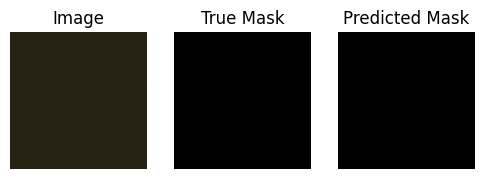

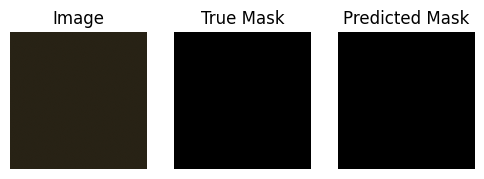

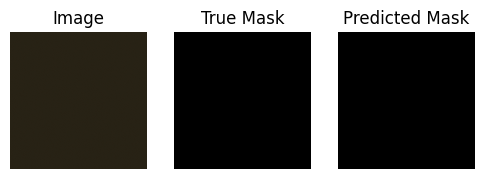

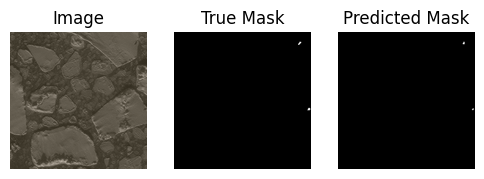

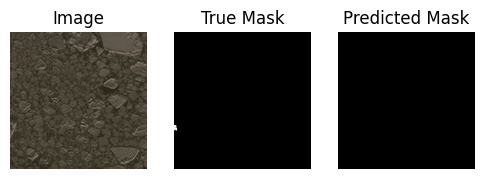

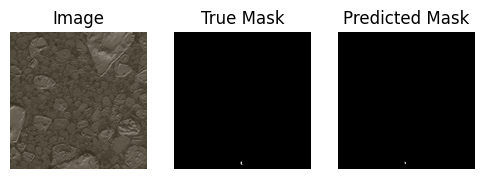

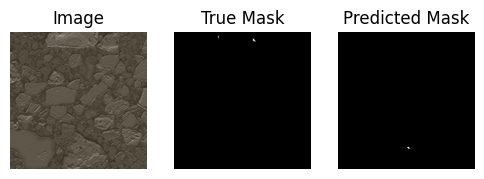

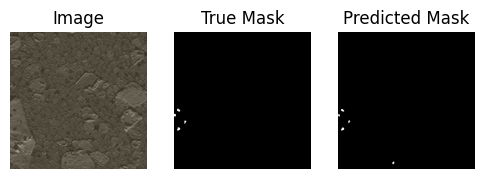

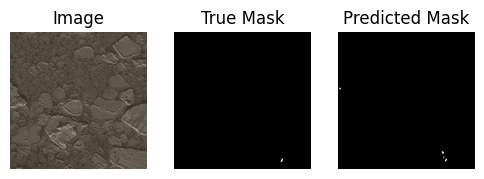

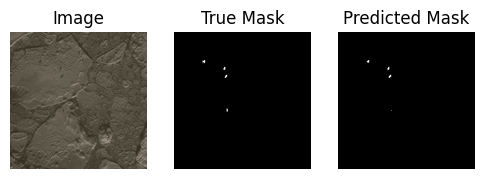

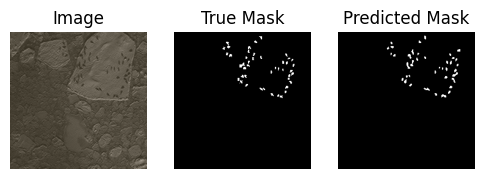

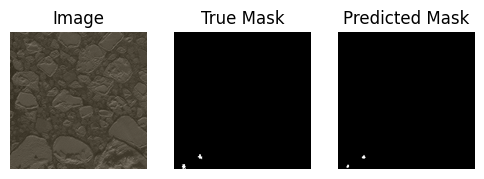

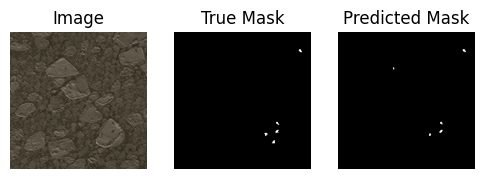

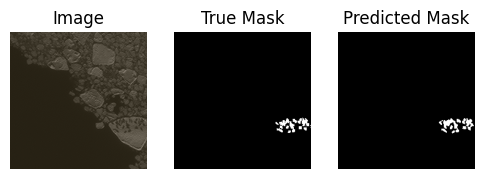

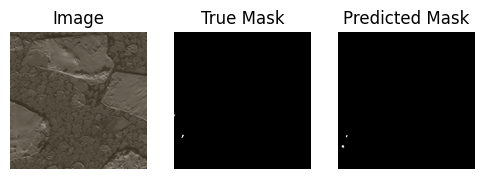

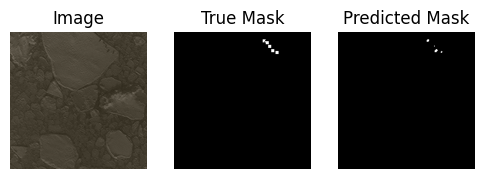

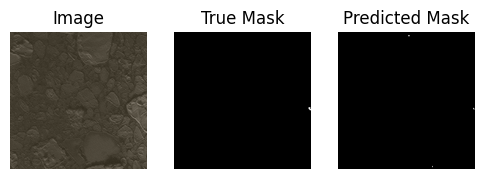

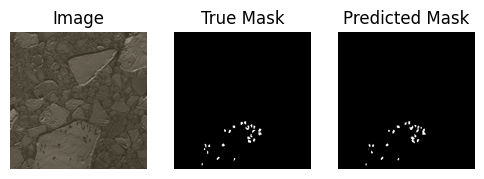

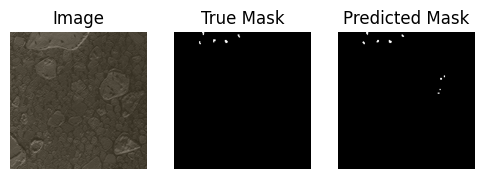

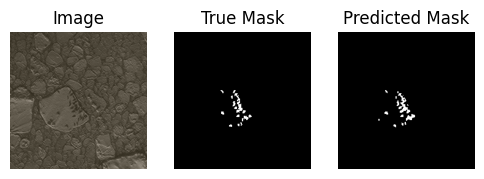

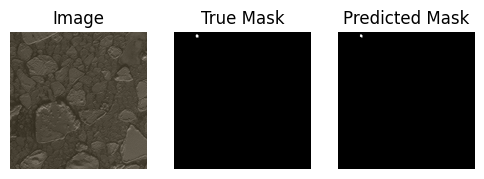

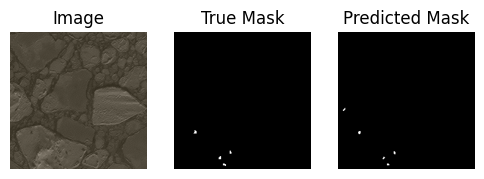

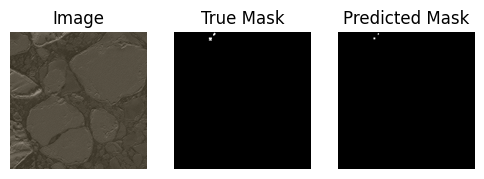

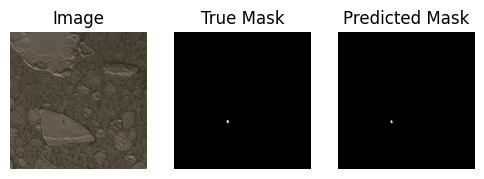

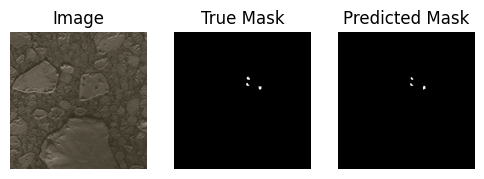

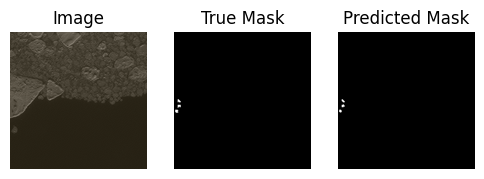

In [37]:
# Visualization all test images!

# Index of the image you want to visualize
for i in range(len(test_dataset)):

# Set visualization variables
  image, mask = test_dataset[i]
  image = image.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension
  mask = mask.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension

  best_model.eval()
  with torch.no_grad():
    pred = model(image)

  pred = torch.sigmoid(pred).squeeze(0).cpu().numpy()  # Convert prediction to numpy array
  pred_print = (pred == 1).astype(float)

  fig, axes = plt.subplots(1, 3, figsize=(6, 2))

  image_np = denormalize(image.squeeze()).cpu().numpy()
  axes[0].imshow(image_np.transpose(1, 2, 0), cmap = 'gray')  # Use grayscale if single channel
  axes[0].set_title('Image')
  axes[0].axis('off')

  mask_np = mask.squeeze().cpu().numpy()
  #print(f'True mask shape for imshow: {mask_np.shape}')
  if channels != 1:
    axes[1].imshow(mask_np.transpose(1, 2, 0), cmap = 'gray')  # Convert mask to numpy array
  else:
    axes[1].imshow(mask_np, cmap = 'gray')

  axes[1].set_title('True Mask')
  axes[1].axis('off')

  #print(f'Predicted mask shape for imshow: {pred_print.shape}')
  axes[2].imshow(pred_print.transpose(1, 2, 0), cmap = 'gray')  # Use grayscale colormap for binary mask
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

plt.show()